In [ ]:
!pip install ultralytics
!pip install supervision==0.1.0

In [ ]:
import os
HOME = os.getcwd()
VIDEO_PATH = f"{HOME}/video.mp4"

In [ ]:
%cd {HOME}
!git clone https://github.com/ifzhang/ByteTrack.git
%cd {HOME}/ByteTrack
!sed -i 's/onnx==1.8.1/onnx==1.9.0/g' requirements.txt
!pip3 install -q -r requirements.txt
!python3 setup.py -q develop
!pip install -q cython_bbox
!pip install -q onemetric
!pip install -q loguru lap thop
import sys
sys.path.append(f"{HOME}/ByteTrack")
%cd {HOME}

In [ ]:
import ultralytics
from supervision.draw.color import ColorPalette
from supervision.geometry.dataclasses import Point
from supervision.video.dataclasses import VideoInfo
from supervision.video.source import get_video_frames_generator
from supervision.video.sink import VideoSink
from supervision.notebook.utils import show_frame_in_notebook
from supervision.tools.detections import Detections, BoxAnnotator
from supervision.tools.line_counter import LineCounter, LineCounterAnnotator
from typing import List
import numpy as np
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass
import cv2

In [ ]:
@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

In [ ]:

def detections2boxes(detections: Detections) -> np.ndarray:
    return np.hstack((
        detections.xyxy,
        detections.confidence[:, np.newaxis]
    ))

def tracks2boxes(tracks: List[STrack]) -> np.ndarray:
    return np.array([
        track.tlbr
        for track
        in tracks
    ], dtype=float)

def match_detections_with_tracks(
    detections: Detections,
    tracks: List[STrack]
) -> Detections:
    if not np.any(detections.xyxy) or len(tracks) == 0:
        return np.empty((0,))

    tracks_boxes = tracks2boxes(tracks=tracks)
    iou = box_iou_batch(tracks_boxes, detections.xyxy)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections)

    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id

    return tracker_ids

In [ ]:
model = ultralytics.YOLO("yolov8x.pt")
model.fuse()

In [ ]:
CLASS_NAMES_DICT = model.model.names
CLASS_NAMES_DICT

In [ ]:
CLASS_ID = [2, 3, 5, 7]
LINE1_START = Point(150, 250)
LINE1_END = Point(800, 250)
TARGET_VIDEO_PATH = f"{HOME}/result.mp4"

In [ ]:
generator = get_video_frames_generator(VIDEO_PATH)
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
iterator = iter(generator)
frame = next(iterator)
results = model(frame)
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int)
)
annotated_frame = box_annotator.annotate(frame=frame, detections=detections)

line1_start = (LINE1_START.x,LINE1_START.y)  
line1_end = (LINE1_END.x,LINE1_END.y) 
line_color = (255, 255, 255)
line_thickness = 2 
annotated_frame_with_line = cv2.line(annotated_frame, line1_start, line1_end, line_color, line_thickness)
%matplotlib inline
show_frame_in_notebook(annotated_frame_with_line, (16, 16))

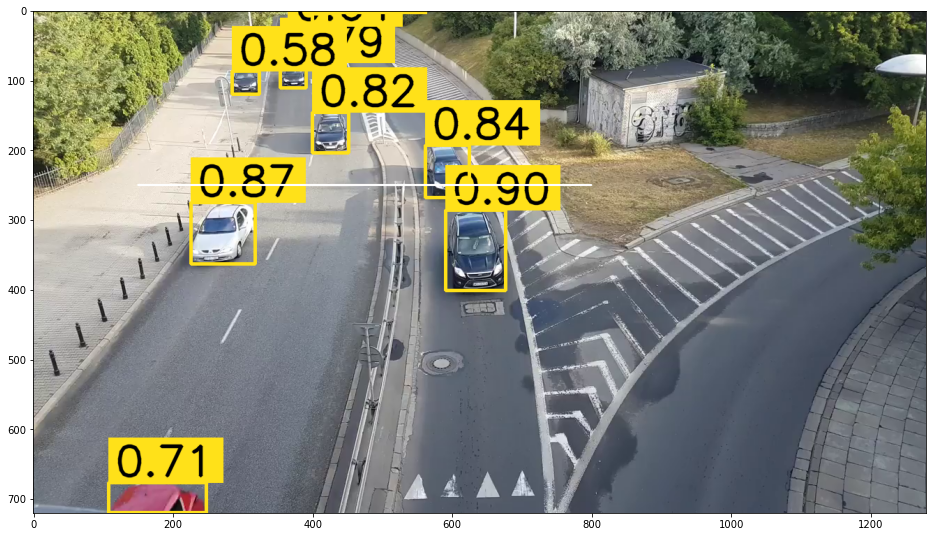

In [ ]:
VideoInfo.from_video_path(VIDEO_PATH)

In [ ]:
byte_tracker = BYTETracker(BYTETrackerArgs())
video_info = VideoInfo.from_video_path(VIDEO_PATH)
generator = get_video_frames_generator(VIDEO_PATH)
line1_counter = LineCounter(start=LINE1_START, end=LINE1_END)
box_annotator = BoxAnnotator(color=ColorPalette(), thickness=4, text_thickness=4, text_scale=2)
line1_annotator = LineCounterAnnotator(thickness=4, text_thickness=4, text_scale=2)

with VideoSink(TARGET_VIDEO_PATH, video_info) as sink:
    for frame in generator:
        results = model(frame)
        detections = Detections(
            xyxy=results[0].boxes.xyxy.cpu().numpy(),
            confidence=results[0].boxes.conf.cpu().numpy(),
            class_id=results[0].boxes.cls.cpu().numpy().astype(int)
        )
        mask = np.array([class_id in CLASS_ID for class_id in detections.class_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        tracks = byte_tracker.update(
            output_results=detections2boxes(detections=detections),
            img_info=frame.shape,
            img_size=frame.shape
        )
        tracker_id = match_detections_with_tracks(detections=detections, tracks=tracks)
        detections.tracker_id = np.array(tracker_id)
        mask = np.array([tracker_id is not None for tracker_id in detections.tracker_id], dtype=bool)
        detections.filter(mask=mask, inplace=True)
        labels = [
            f"#{tracker_id} {CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
            for _, confidence, class_id, tracker_id
            in detections
        ]
        line1_counter.update(detections=detections)
        frame = box_annotator.annotate(frame=frame, detections=detections, labels=labels)
        line1_annotator.annotate(frame=frame, line_counter=line1_counter)
        sink.write_frame(frame)